# Ukraine country profile

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:6385' 
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/UA_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    fn=fn.replace("\\",'/')
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'

auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Ukraine',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})

response.raise_for_status()
df = pd.DataFrame.from_records(response.json())

df=df[df['fnid']!='UA']
df=df[df['fnid']!='UA1962A0']

# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1962	 | UA1962A1 | 27	| nan	| 0	| nan	| 0	|
| 2022	 | UA2022A1 | 27	| UA2022A2	| 139	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Save data
df_raw_out = '../data/crop_raw_data/adm_crop_data_raw_UA.csv'
df.to_csv(df_raw_out); print(f'{df_raw_out} is saved.')

../data/crop_raw_data/adm_crop_data_raw_UA.csv is saved.


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #


#create a df that has one value per duplicated value
toFill = df[df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]# find all duplicates
toFill = toFill[~toFill[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep='first')]# keep only one

# toFill = toFill.merge(dupes, how='left',on = ['fnid','season_year','indicator','crop_production_system','product'])
#drop all duplicate obs from original DF and append the filled DF
df = df[~df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]
df = df.append(toFill)
#becasue the population groups have been recombined, set them all equal to 'none'
df['population_group'] = 'none'

#5) limit to areas with collected data
df = df[df['status'] == 'Collected']

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #
# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([UA_Admin1_1962,UA_Admin1_2022], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 32,555
Removed 6,267 "Missing Value" points
8,643/10,693 "Area Harvested" points are retained.
9,045/11,180 "Quantity Produced" points are retained.
8,600/10,682 "Yield" points are retained.
Current data points: 26,288

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1990 - 2023
56 grain types are found: Annual grass fodder (unspecified), Barley (Unspecified), Beans (mixed), Beet fodder, Buckwheat (unspecified), Cabbage (Unspecified), Carrots, Cauliflowers, Chick Peas, Chili pepper (Unspecified), Coriander, Cucumber, Dill, Eggplant, Fodder (Gourd), Fodder grass (unspecified), Fodder root (unspecified), Garlic (fresh), Green Fodder, Green pea, Horse beans, Hot Chili Peppers (dry), Leeks, Lentils, Linseed (unspecified), Maize (Corn), Maize fodder, Maize/corn grain (sweet), Melon (unspecified), Millet, Mung bean, n.e.c., Mustard seed (unspecified), Napa

- Recorded years per season ------------------- #
Calendar year: 34 years (1990-2023) (missing: 8 years)
Spring Crop Season: 10 years (2014-2023) (missing: 0 years)
Winter Crop Season: 10 years (2014-2023) (missing: 0 years)

- Number of "Quantity Produced" data points --- #
UA1962A1: 9,045 data points are found.

- Districts with population group(s) ---------- #
0 districts includes 'population_group'.

Table of available data
----------------------------------------------- #
Crop type: Annual grass fodder (unspecified)
----------------------------------------------- #
season_name            Calendar year
crop_production_system      All (PS)
fnid_short                    1962A1
year                                
2022                           18/27
2023                           18/27
----------------------------------------------- #
Crop type: Barley (Unspecified)
----------------------------------------------- #
season_name            Calendar year Spring Crop Season Winter Crop S

../figures/UA_admin_shapes.png is saved.


- Ukraine crop seasonal calendar

<img src="https://ipad.fas.usda.gov/countrysummary/images/UP/cropcalendar/umb_up_1_calendar.png" width=900>

- FDW data consists of `UA1962A1`, `UA2022A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |Admin3   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |:---:  |:---:  |
| 1962	 | UA1962A1 | 27	| nan	| 0	| nan	| 0	|
| 2022	 | UA2022A1 | 27	| UA2022A2	| 139	| nan	| 0	|

- Comparison between admin boundaries.

<img src="../figures/UA_admin_shapes.png" width=900>


- **`UA1962A1`** is used to represent all admin-level 1 crop data.
- Ukraine has three crop seasons: `Annual `, `Winter Crop Seanson`, `Spring Crop Seanson`.
- Ukraine has a single crop production system: `none`.

In [5]:

# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = UA_Admin1_1962.copy().to_crs('epsg:6385')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Link admin boundaries ------------------------- #
link_1962, over_1962 = FDW_PD_CreateAdminLink(UA_Admin1_1962, UA_Admin1_1962, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link_1962, prod, over_1962, mdx_pss)

for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

CBR is considered for 'UA1962A130' as no record found in: ['UA1962A130']
CBR is considered for 'UA1962A140' as no record found in: ['UA1962A140']


In [7]:
# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
# stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_UA.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_UA_ratio.npz', link_ratio)


../data/crop/adm_crop_production_UA.csv is saved.
../data/crop/adm_crop_production_UA_ratio.npz is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


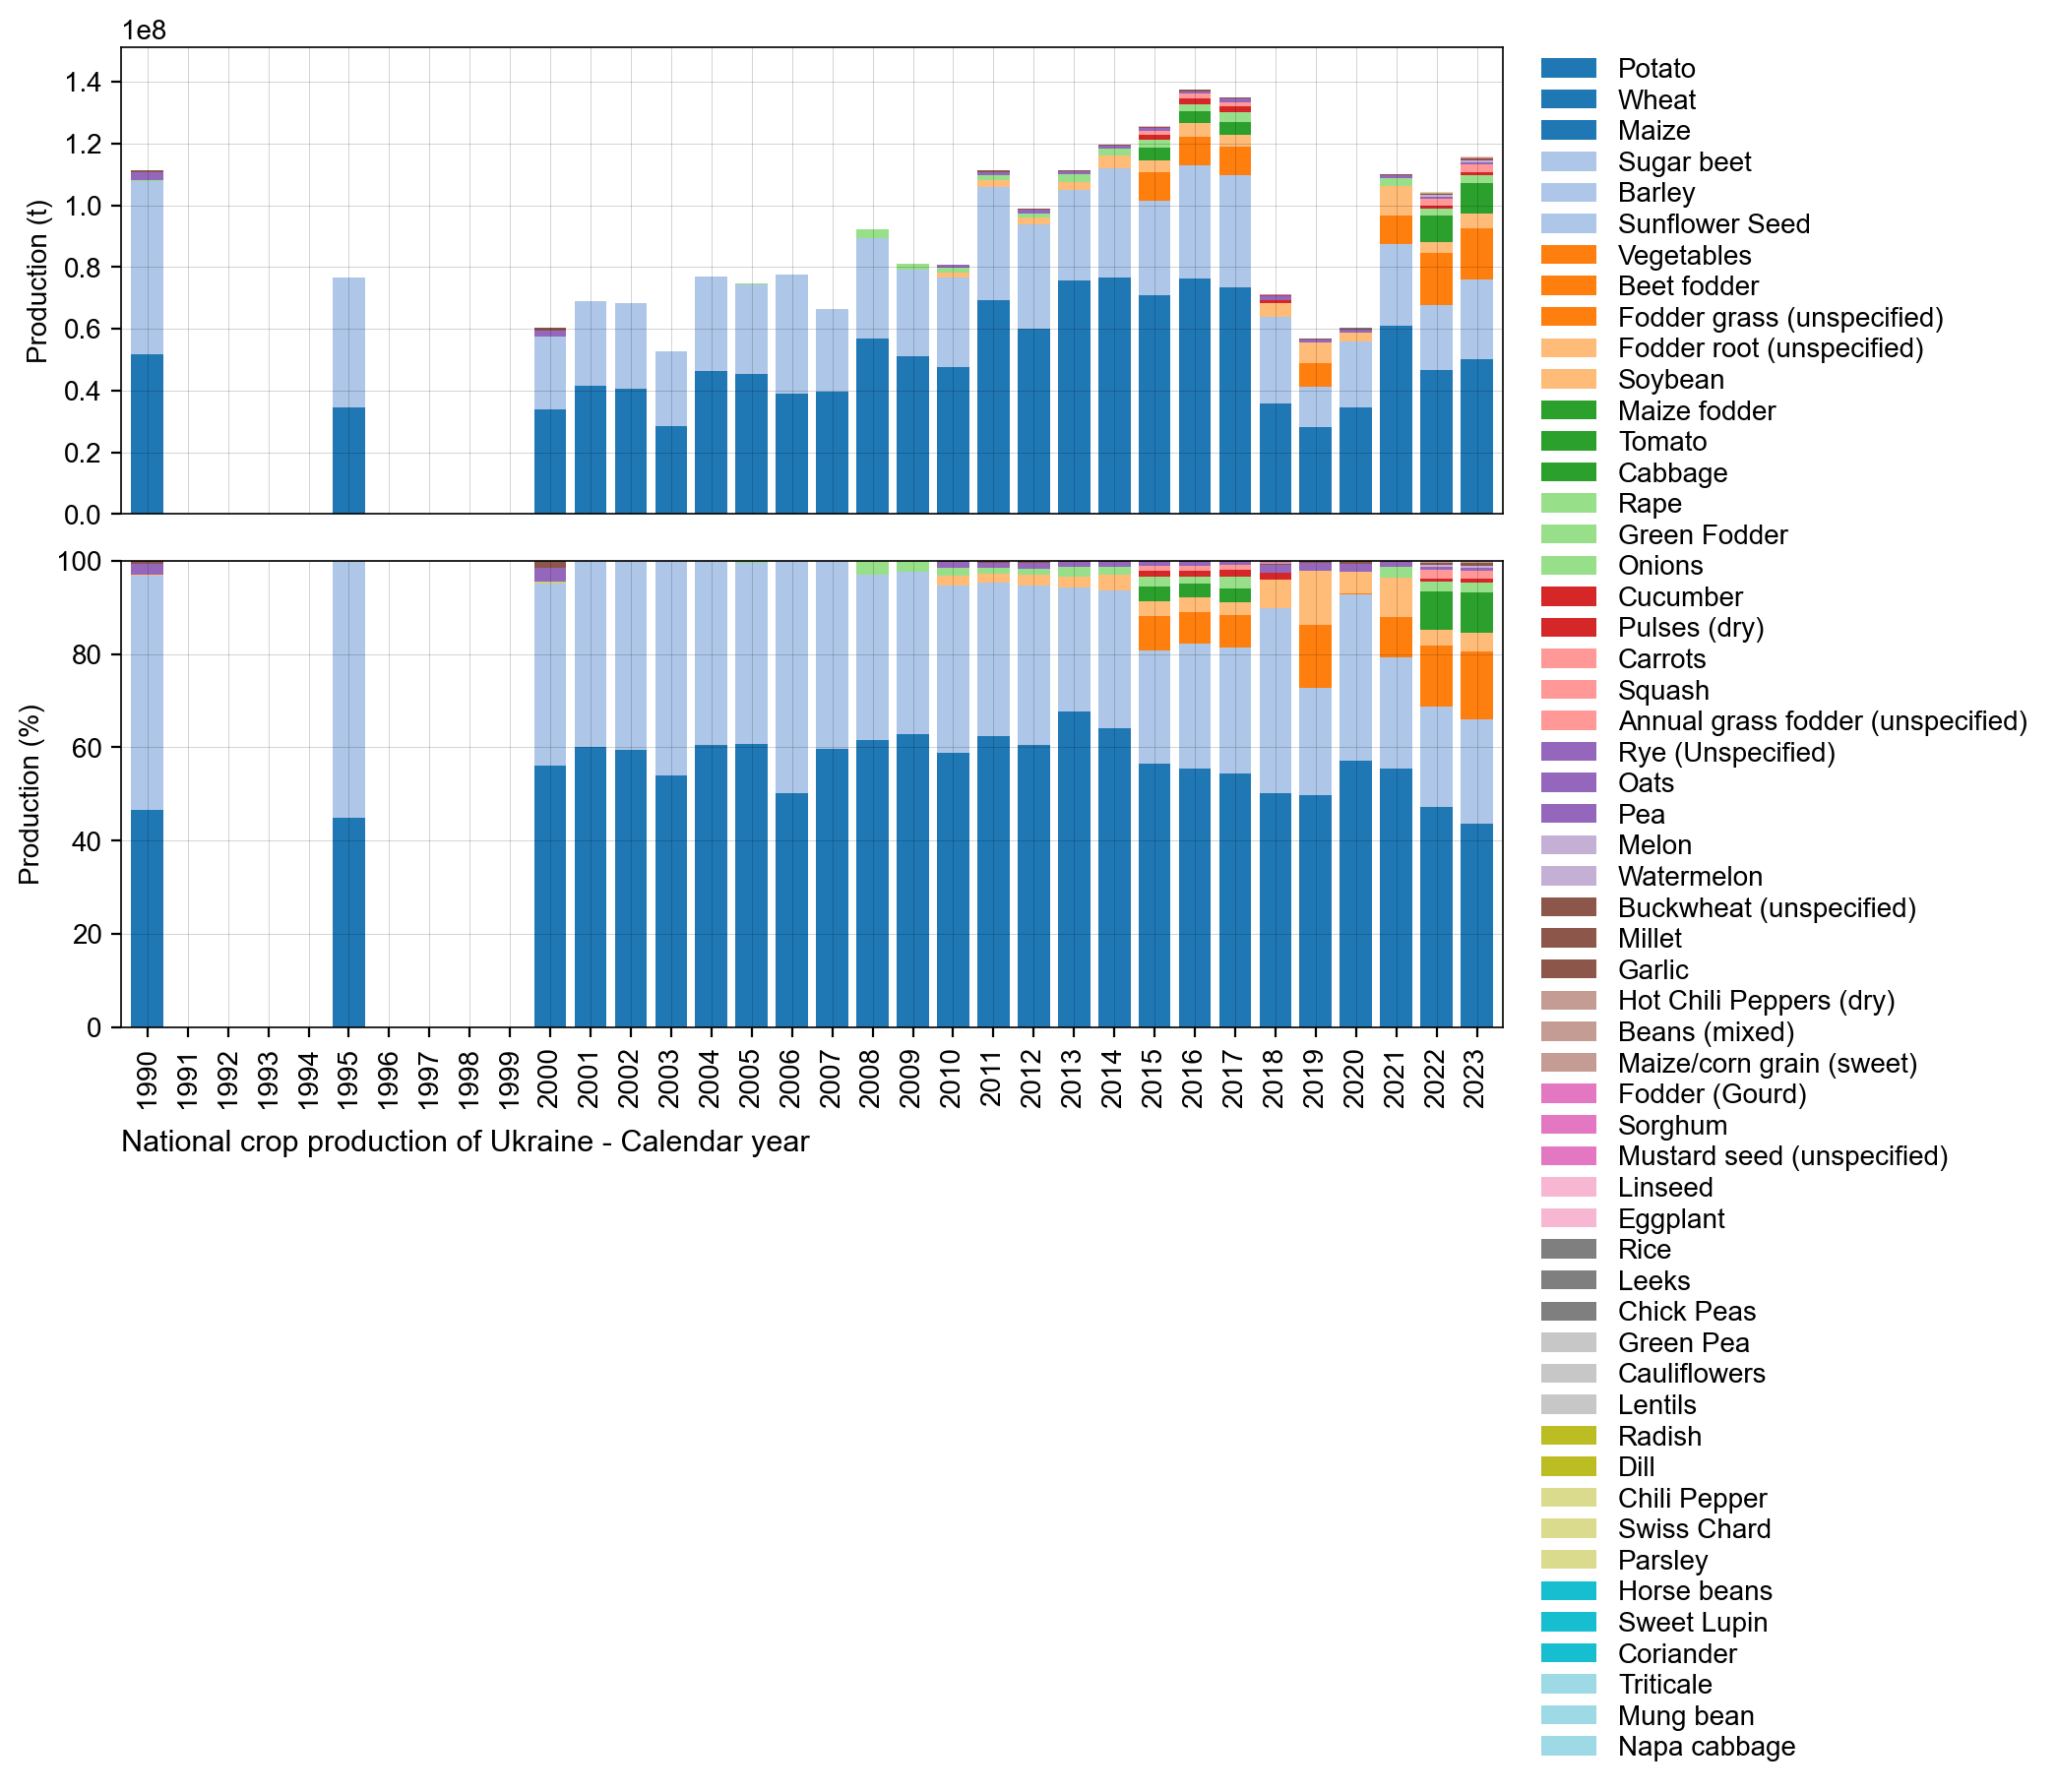

../figures/UA_bar_natgrainprod_Calendar year.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


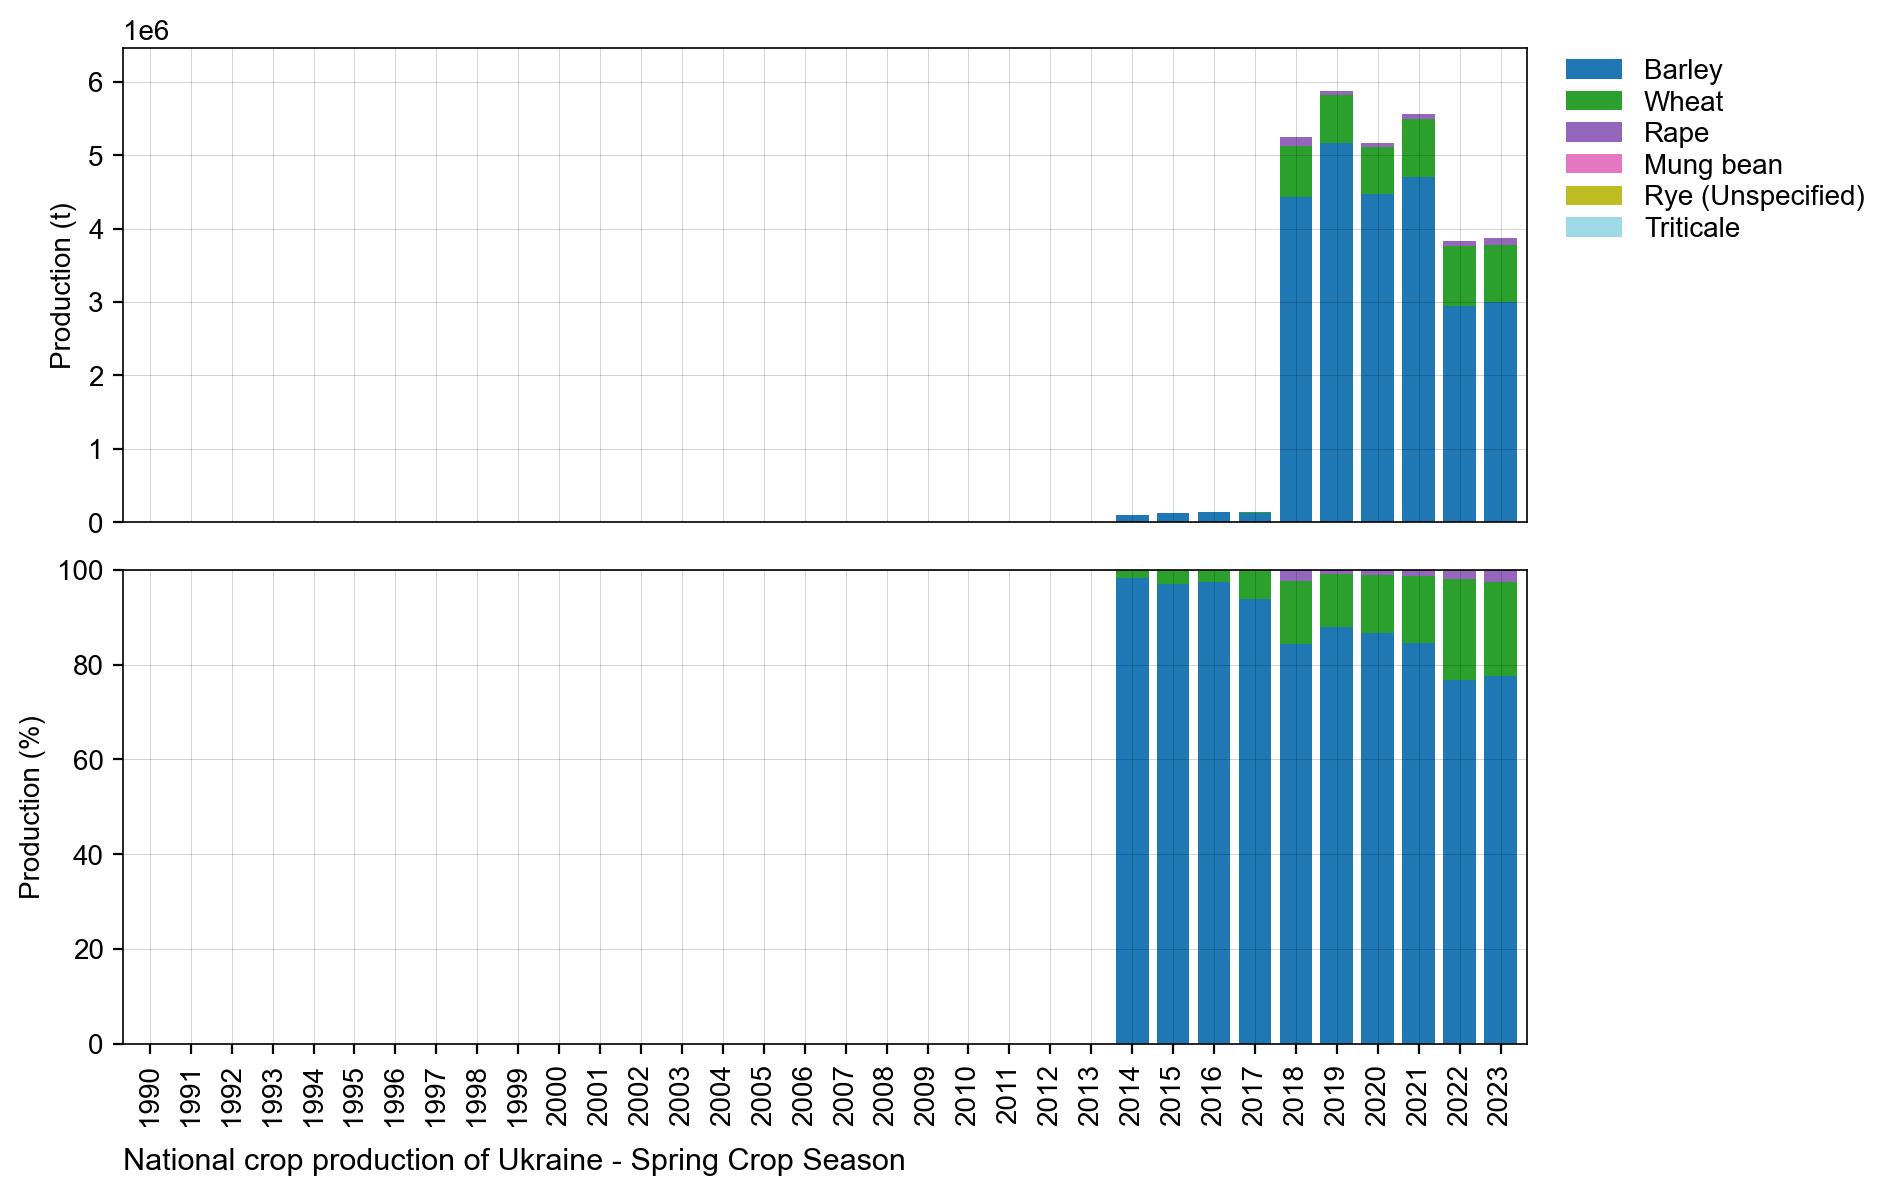

../figures/UA_bar_natgrainprod_Spring Crop Season.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


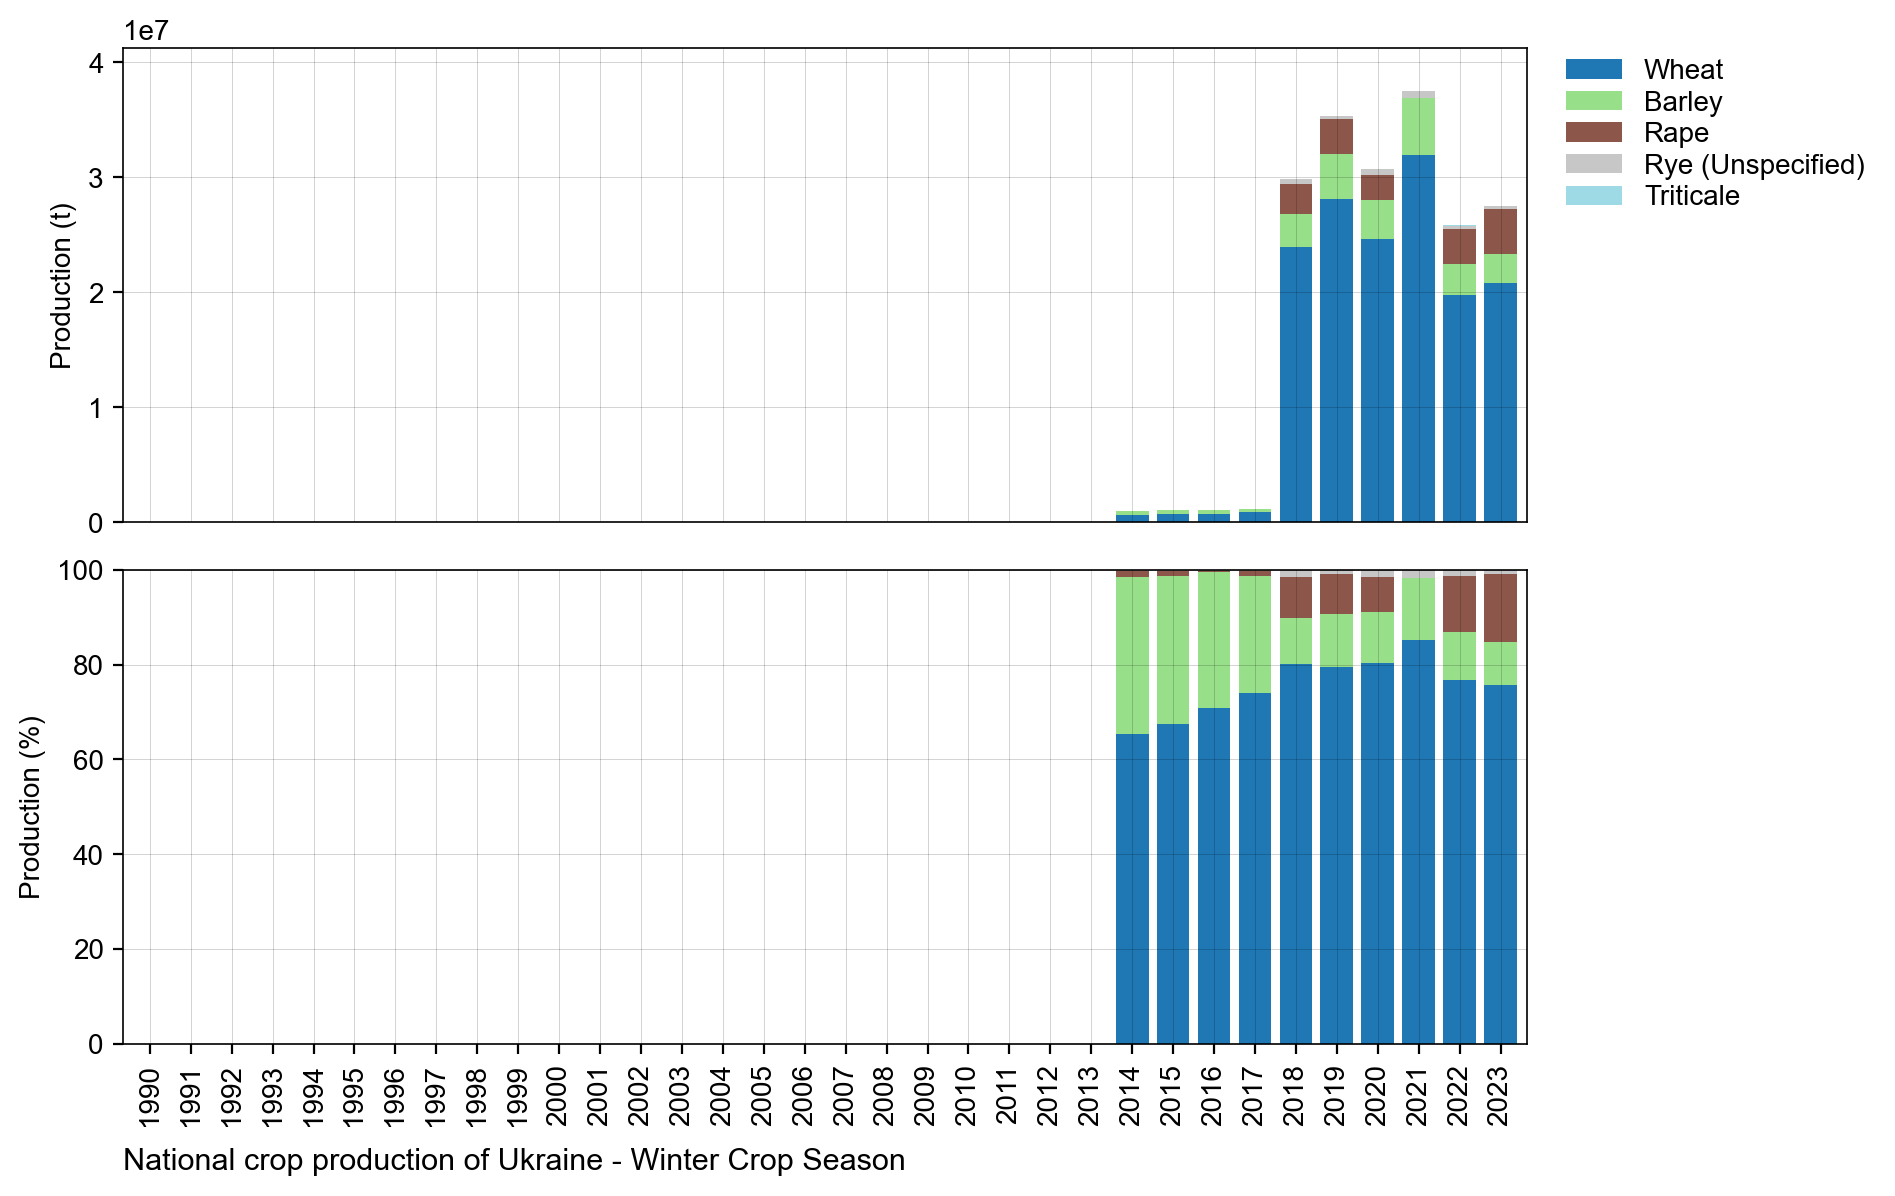

../figures/UA_bar_natgrainprod_Winter Crop Season.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'UA', 'Ukraine'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Calendar year', 'Spring Crop Season', 'Winter Crop Season']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    
    
    PlotBarProduction(sub, year, footnote, fn_save)

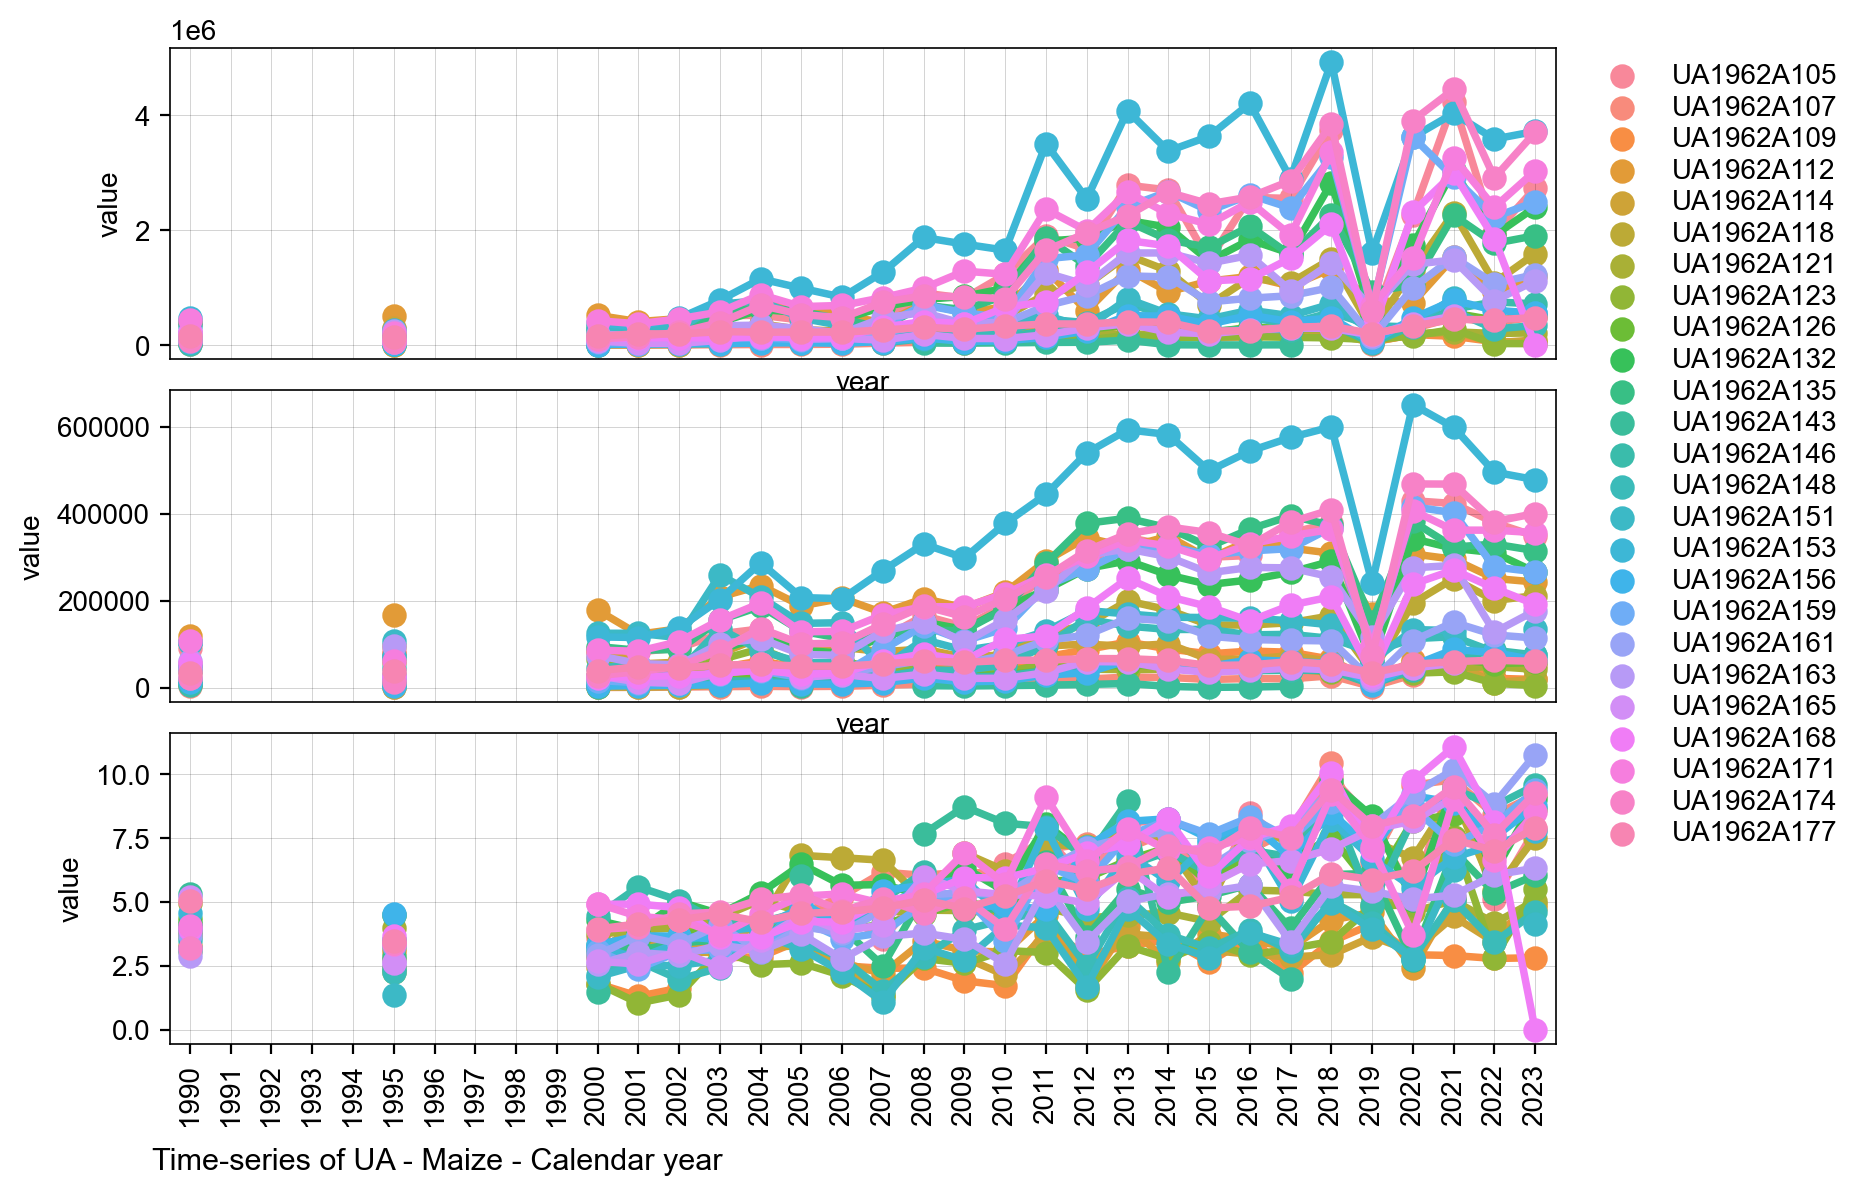

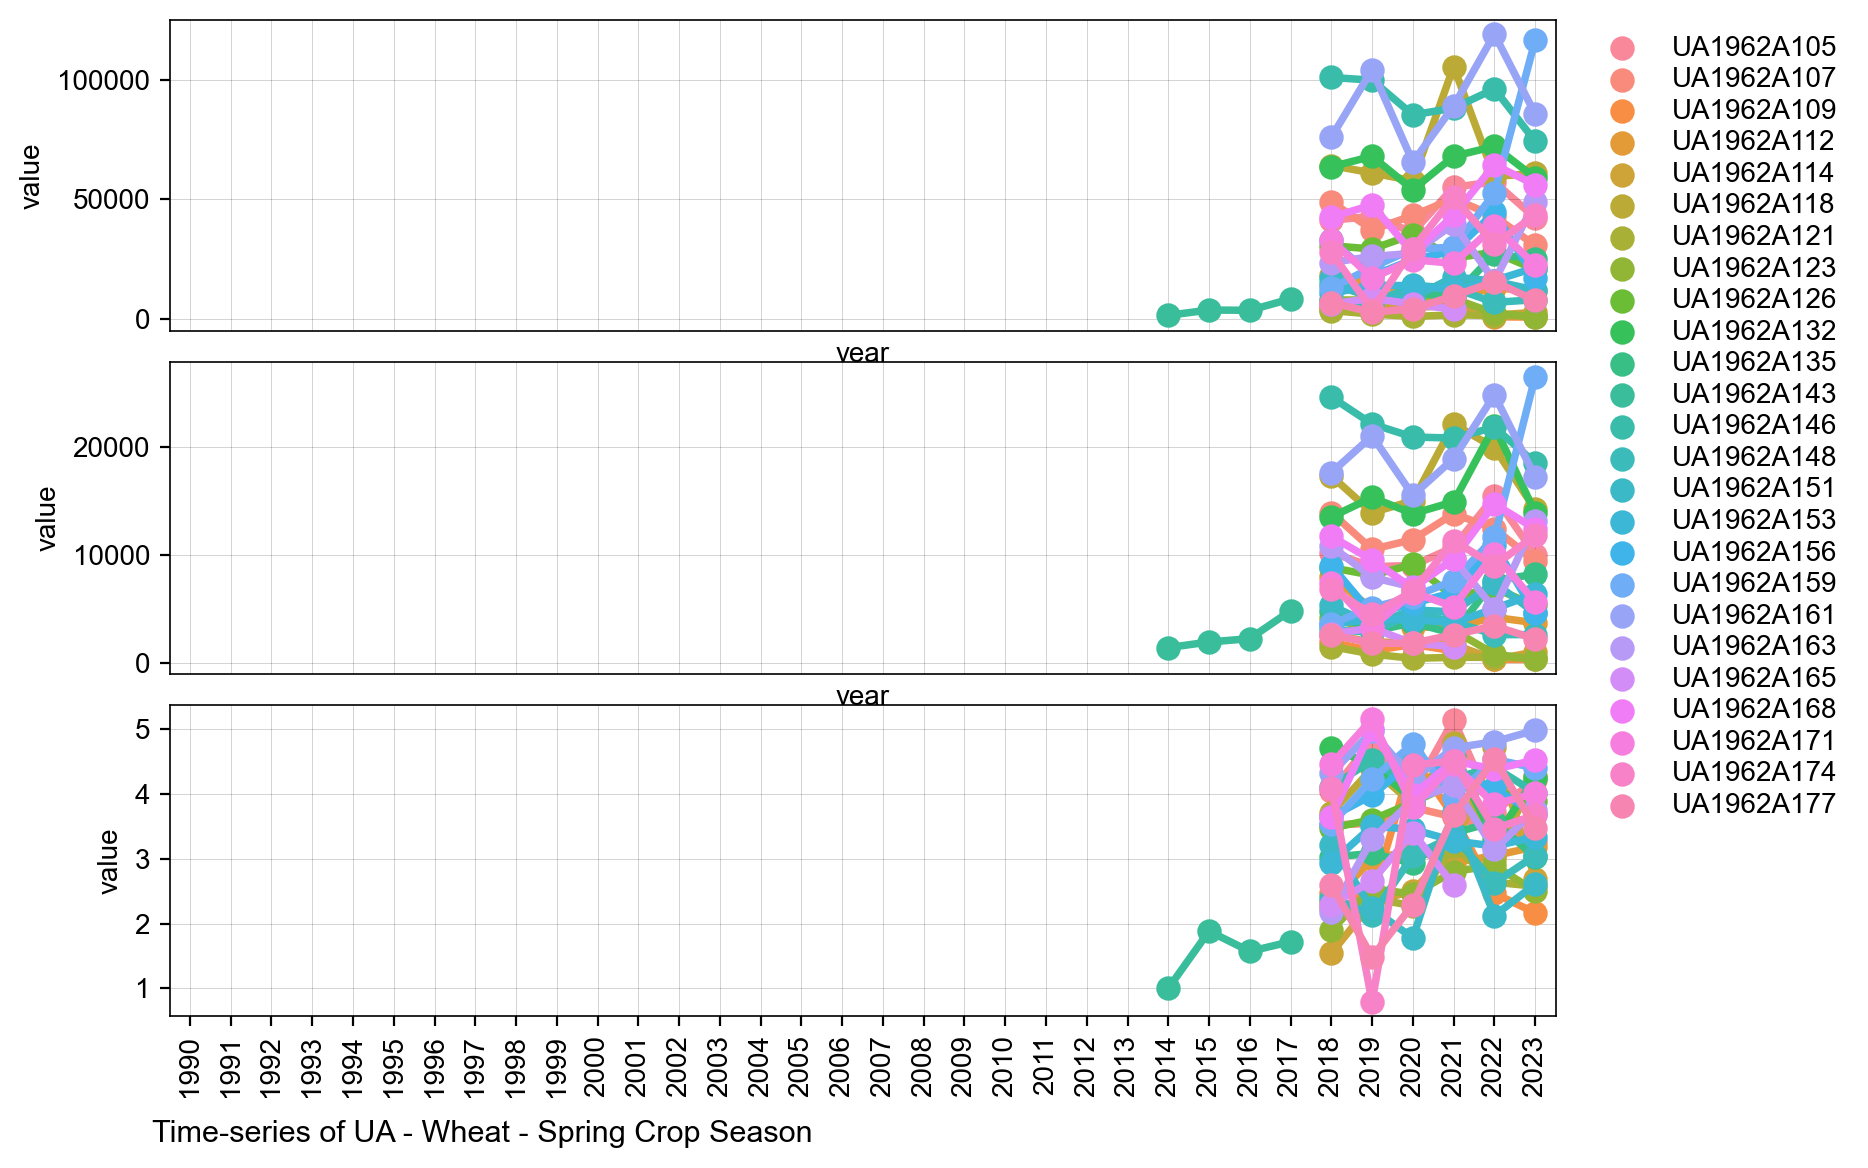

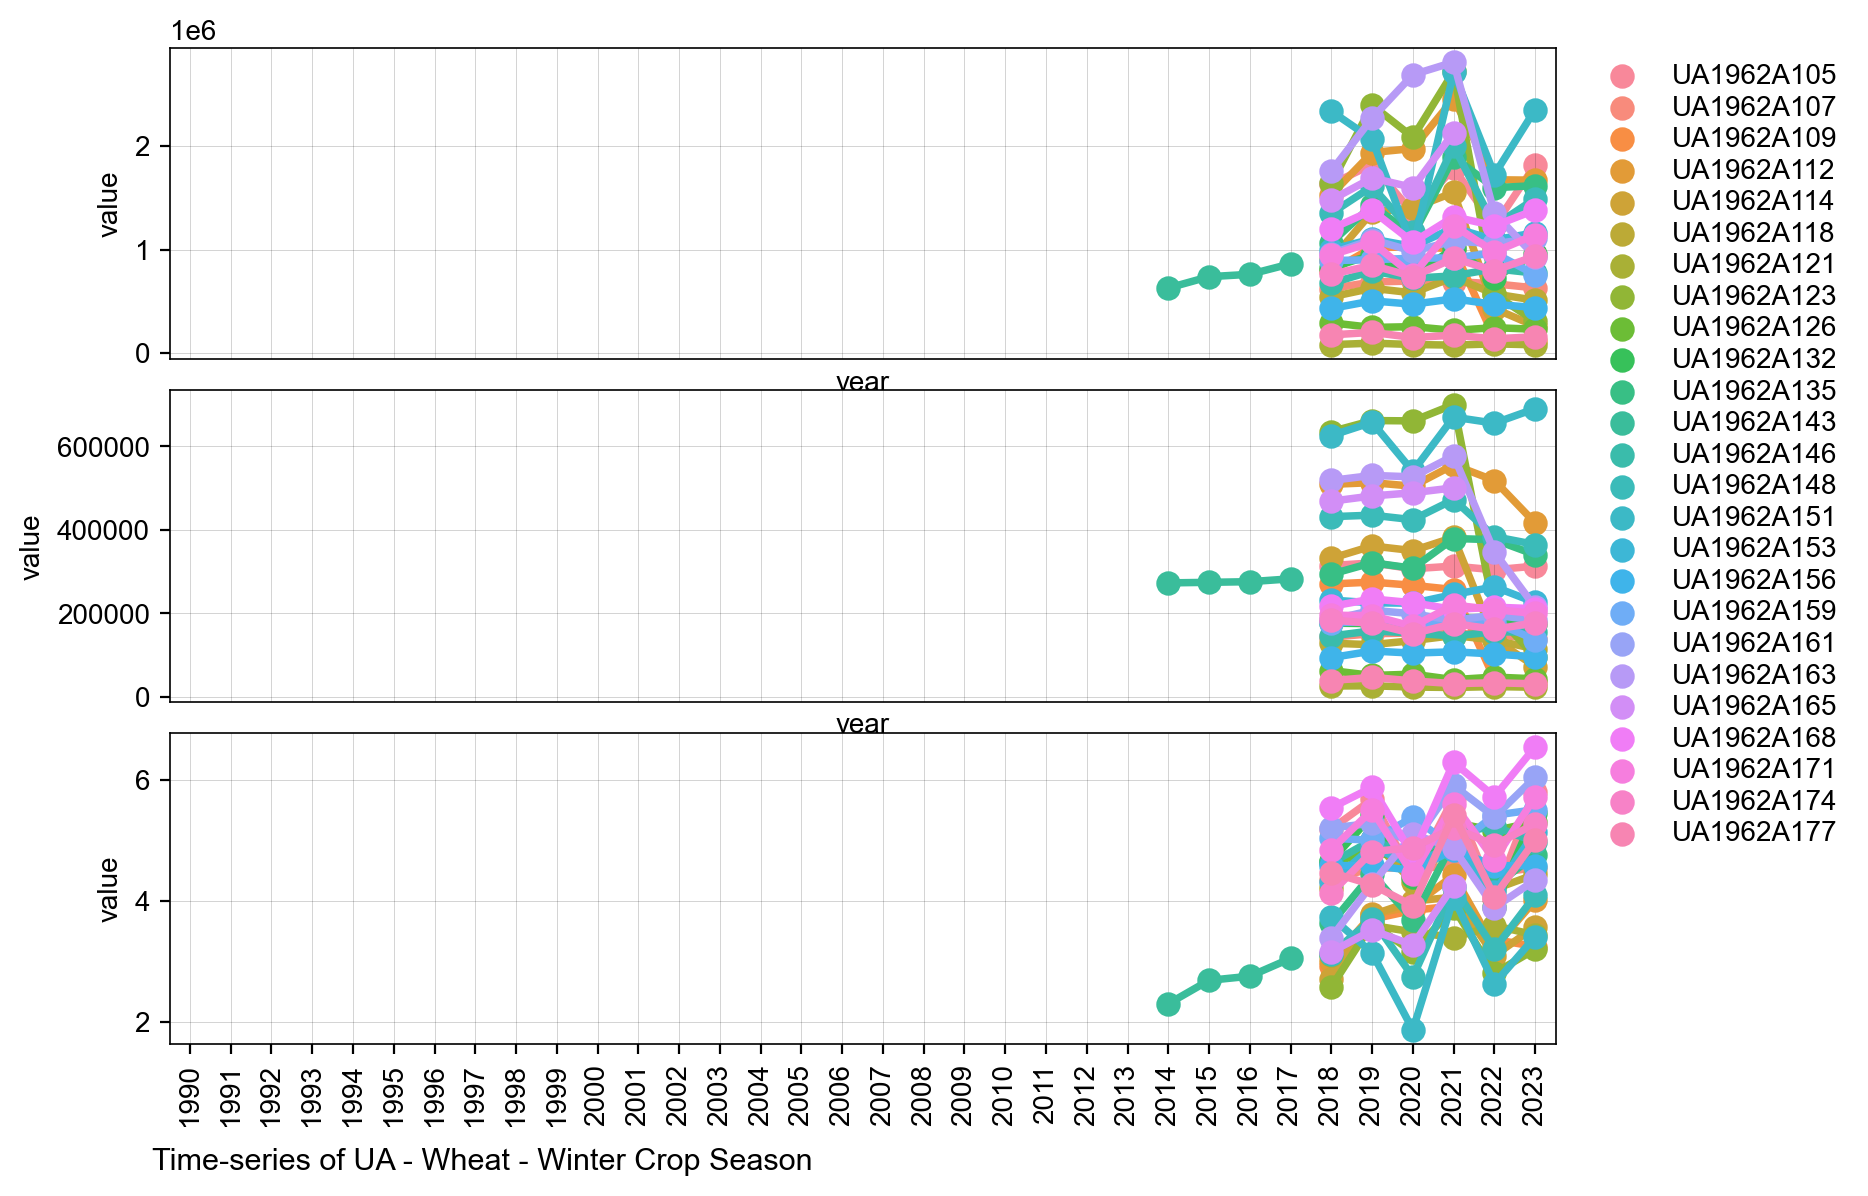

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'UA', 'Ukraine'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
# df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Calendar year'],
    ['Wheat','Spring Crop Season'],
    ['Wheat','Winter Crop Season'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)